ANALISIS SENTIMEN ULASAN GOOGLE MAPS UNIVERSITAS PGRI SEMARANG
Aspect-Based Sentiment Classification (ABSC) dengan SVM
Author: [Yudha Ananda Ramadhan]

**BAGIAN 1: INSTALASI DAN IMPORT LIBRARY**

In [1]:
# Install library yang diperlukan
!pip install sastrawi
!pip install wordcloud
!pip install openpyxl
!pip install seaborn
!pip install scikit-learn
!pip install matplotlib

# Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
from datetime import datetime
from collections import Counter

# NLP Libraries
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, precision_recall_fscore_support,
                             roc_auc_score, roc_curve)
from wordcloud import WordCloud

warnings.filterwarnings('ignore')
plt.style.use('ggplot')
sns.set_palette("husl")

print("✓ Semua library berhasil diimport!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.8 MB/s eta 0:00:00
✓ Semua library berhasil diimport!


**BAGIAN 2: UPLOAD DAN LOAD DATA**

In [3]:
# Load dataset
df = pd.read_csv('dataset_review_gmaps.csv')

print(f"\n{'='*60}")
print(f"INFORMASI DATASET")
print(f"{'='*60}")
print(f"Jumlah data: {len(df)}")
print(f"Jumlah kolom: {len(df.columns)}")
print(f"\nNama kolom: {list(df.columns)}")
print(f"\n5 Data Pertama:")
print(df.head())


INFORMASI DATASET
Jumlah data: 959
Jumlah kolom: 6

Nama kolom: ['title', 'url', 'stars', 'name', 'reviewUrl', 'text']

5 Data Pertama:
                       title  \
0  Universitas PGRI Semarang   
1  Universitas PGRI Semarang   
2  Universitas PGRI Semarang   
3  Universitas PGRI Semarang   
4  Universitas PGRI Semarang   

                                                 url  stars  \
0  https://www.google.com/maps/search/?api=1&quer...      5   
1  https://www.google.com/maps/search/?api=1&quer...      5   
2  https://www.google.com/maps/search/?api=1&quer...      5   
3  https://www.google.com/maps/search/?api=1&quer...      1   
4  https://www.google.com/maps/search/?api=1&quer...      1   

                               name  \
0                Ahmad fathun ni'am   
1  Artasindo Medika (Rumah Oksigen)   
2                           jasmine   
3             Zhalzabila Rahmadhani   
4                              kyla   

                                           reviewUrl  \


**BAGIAN 3: PENGECEKAN AWAL & EKSPLORASI DATA**

In [5]:
print(f"\n{'='*60}")
print(f"PENGECEKAN KUALITAS DATA")
print(f"{'='*60}")

# Missing values
print("\n1. Missing Values:")
print(df.isnull().sum())

# Duplicates
duplicates = df.duplicated().sum()
print(f"\n2. Duplikasi data: {duplicates}")

# Info tipe data
print("\n3. Info Dataset:")
print(df.info())

# Statistik deskriptif untuk kolom Stars
print("\n4. Statistik Rating (stars):")
print(df['stars'].describe())


PENGECEKAN KUALITAS DATA

1. Missing Values:
title          0
url            0
stars          0
name           0
reviewUrl      0
text         644
dtype: int64

2. Duplikasi data: 0

3. Info Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 959 entries, 0 to 958
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      959 non-null    object
 1   url        959 non-null    object
 2   stars      959 non-null    int64 
 3   name       959 non-null    object
 4   reviewUrl  959 non-null    object
 5   text       315 non-null    object
dtypes: int64(1), object(5)
memory usage: 45.1+ KB
None

4. Statistik Rating (stars):
count    959.000000
mean       4.680918
std        0.785011
min        1.000000
25%        5.000000
50%        5.000000
75%        5.000000
max        5.000000
Name: stars, dtype: float64


**BAGIAN 4: CLEANING DATA AWAL**

In [9]:
# Backup data original
df_original = df.copy()

# Hapus missing values di kolom penting
df = df.dropna(subset=['text', 'stars'])

# Hapus duplikat berdasarkan review text
df = df.drop_duplicates(subset=['text'], keep='first')

# Reset index
df = df.reset_index(drop=True)

print(f"\n{'='*60}")
print(f"HASIL CLEANING AWAL")
print(f"{'='*60}")
print(f"Data sebelum: {len(df_original)}")
print(f"Data sesudah: {len(df)}")
print(f"Data terhapus: {len(df_original) - len(df)}")


HASIL CLEANING AWAL
Data sebelum: 315
Data sesudah: 302
Data terhapus: 13


**BAGIAN 5: EKSPLORASI DATA & VISUALISASI**

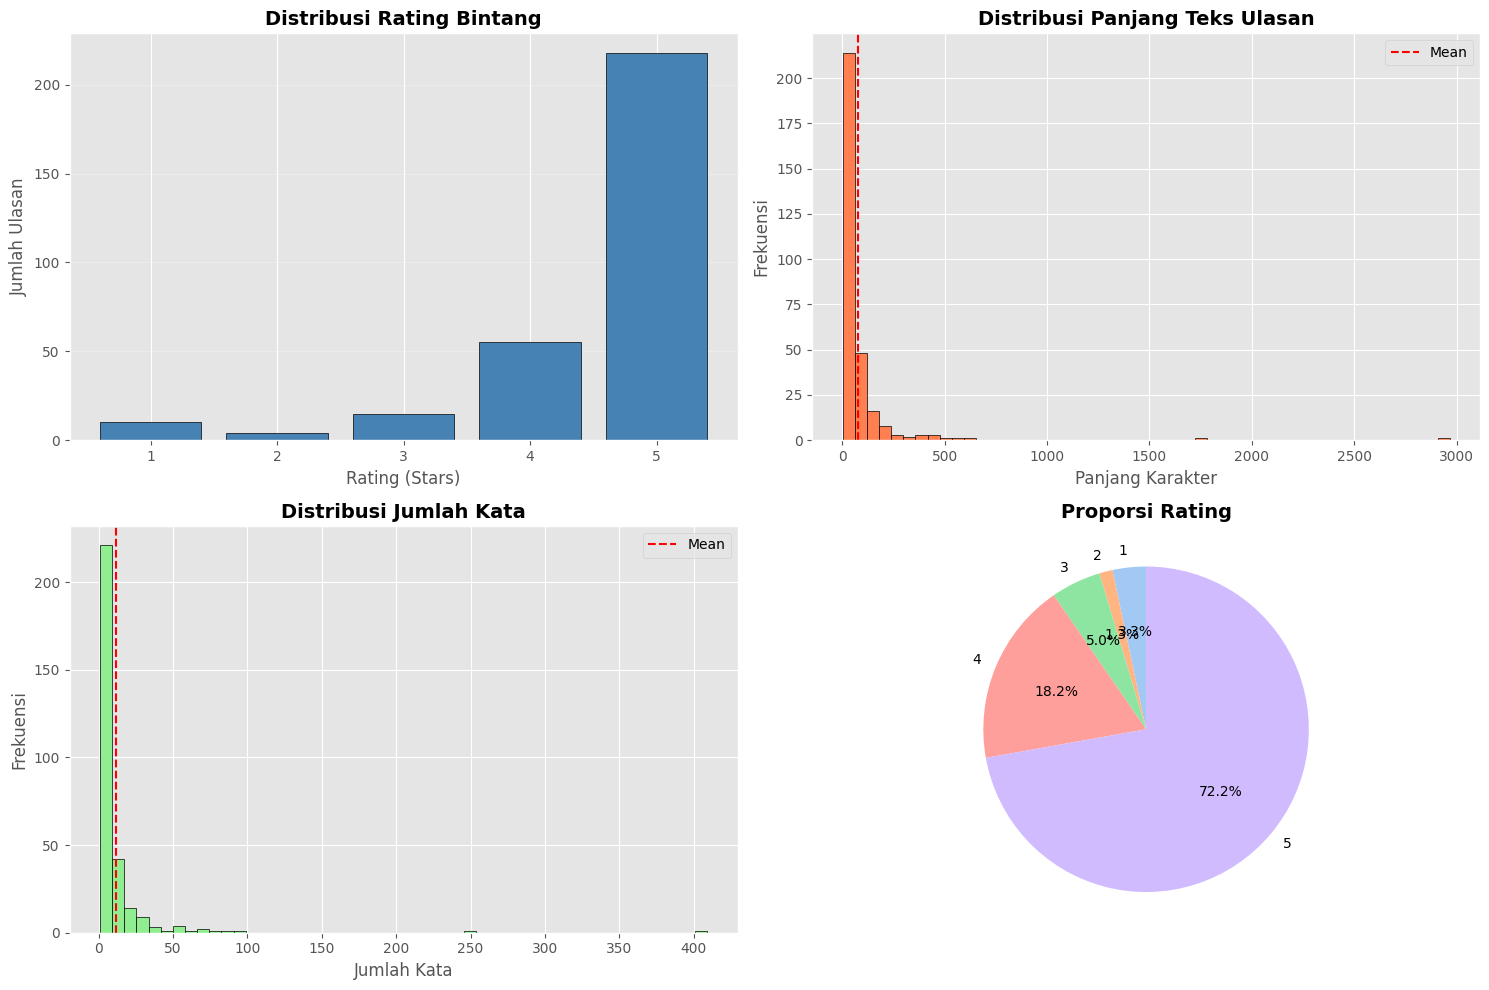


STATISTIK EKSPLORASI
Rata-rata panjang teks: 78.54 karakter
Rata-rata jumlah kata: 11.55 kata
Rating tertinggi: 5
Rating terendah: 1
Rating rata-rata: 4.55


In [13]:
# 5.1 Distribusi Rating
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Distribusi Stars
star_counts = df['stars'].value_counts().sort_index()
axes[0, 0].bar(star_counts.index, star_counts.values, color='steelblue', edgecolor='black')
axes[0, 0].set_title('Distribusi Rating Bintang', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Rating (Stars)')
axes[0, 0].set_ylabel('Jumlah Ulasan')
axes[0, 0].grid(axis='y', alpha=0.3)

# Plot 2: Distribusi Panjang Teks
df['text_length'] = df['text'].str.len()
axes[0, 1].hist(df['text_length'], bins=50, color='coral', edgecolor='black')
axes[0, 1].set_title('Distribusi Panjang Teks Ulasan', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Panjang Karakter')
axes[0, 1].set_ylabel('Frekuensi')
axes[0, 1].axvline(df['text_length'].mean(), color='red', linestyle='--', label='Mean')
axes[0, 1].legend()

# Plot 3: Distribusi Jumlah Kata
df['word_count'] = df['text'].str.split().str.len()
axes[1, 0].hist(df['word_count'], bins=50, color='lightgreen', edgecolor='black')
axes[1, 0].set_title('Distribusi Jumlah Kata', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Jumlah Kata')
axes[1, 0].set_ylabel('Frekuensi')
axes[1, 0].axvline(df['word_count'].mean(), color='red', linestyle='--', label='Mean')
axes[1, 0].legend()

# Plot 4: Pie Chart Rating
axes[1, 1].pie(star_counts.values, labels=star_counts.index, autopct='%1.1f%%',
               startangle=90, colors=sns.color_palette('pastel'))
axes[1, 1].set_title('Proporsi Rating', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('eksplorasi_data.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n{'='*60}")
print(f"STATISTIK EKSPLORASI")
print(f"{'='*60}")
print(f"Rata-rata panjang teks: {df['text_length'].mean():.2f} karakter")
print(f"Rata-rata jumlah kata: {df['word_count'].mean():.2f} kata")
print(f"Rating tertinggi: {df['stars'].max()}")
print(f"Rating terendah: {df['stars'].min()}")
print(f"Rating rata-rata: {df['stars'].mean():.2f}")

**BAGIAN 6: TEXT PREPROCESSING**

In [15]:
print(f"\n{'='*60}")
print(f"MEMULAI TEXT PREPROCESSING")
print(f"{'='*60}")

# Inisialisasi Sastrawi
factory_stemmer = StemmerFactory()
stemmer = factory_stemmer.create_stemmer()

factory_stopword = StopWordRemoverFactory()
stopword_list = factory_stopword.get_stop_words()

# Custom stopwords (kata yang tidak informatif untuk konteks ini)
custom_stopwords = ['universitas', 'upgris', 'semarang', 'pgri', 'kampus',
                    'univ', 'university', 'kota']
stopword_list.extend(custom_stopwords)

# Dictionary normalisasi kata gaul
normalization_dict = {
    'kampusnya': 'kampus',
    'mahasiswanya': 'mahasiswa',
    'gk': 'tidak',
    'ga': 'tidak',
    'gak': 'tidak',
    'bgt': 'banget',
    'bgt': 'banget',
    'bner': 'benar',
    'bgs': 'bagus',
    'bgus': 'bagus',
    'keren': 'bagus',
    'mantap': 'bagus',
    'mantul': 'bagus',
    'oke': 'baik',
    'ok': 'baik',
    'jelek': 'buruk',
    'ancur': 'buruk',
    'parah': 'buruk',
    'recommended': 'rekomendasi',
    'recommend': 'rekomendasi'
}

def clean_text(text):
    """
    Fungsi preprocessing lengkap untuk teks bahasa Indonesia
    """
    if pd.isna(text):
        return ""

    # 1. Case folding
    text = text.lower()

    # 2. Cleaning
    # Hapus URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # Hapus mention dan hashtag
    text = re.sub(r'@\w+|#\w+', '', text)
    # Hapus HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Hapus emoji dan simbol
    text = re.sub(r'[^\w\s]', ' ', text)
    # Hapus angka
    text = re.sub(r'\d+', '', text)
    # Hapus extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # 3. Normalisasi kata gaul
    words = text.split()
    words = [normalization_dict.get(word, word) for word in words]
    text = ' '.join(words)

    # 4. Tokenizing (sudah dilakukan di step sebelumnya)

    # 5. Stopword removal
    words = text.split()
    words = [word for word in words if word not in stopword_list and len(word) > 2]
    text = ' '.join(words)

    # 6. Stemming
    text = stemmer.stem(text)

    return text

# Terapkan preprocessing
print("Memproses teks... (ini mungkin butuh beberapa menit)")
df['clean_text'] = df['text'].apply(clean_text)

# Hapus teks kosong setelah preprocessing
df = df[df['clean_text'].str.len() > 0].reset_index(drop=True)

print(f"\n✓ Preprocessing selesai!")
print(f"Total data setelah preprocessing: {len(df)}")

# Tampilkan contoh hasil preprocessing
print(f"\n{'='*60}")
print(f"CONTOH HASIL PREPROCESSING")
print(f"{'='*60}")
for i in range(3):
    print(f"\nContoh {i+1}:")
    print(f"Original: {df['text'].iloc[i][:100]}...")
    print(f"Cleaned : {df['clean_text'].iloc[i][:100]}...")


MEMULAI TEXT PREPROCESSING
Memproses teks... (ini mungkin butuh beberapa menit)

✓ Preprocessing selesai!
Total data setelah preprocessing: 294

CONTOH HASIL PREPROCESSING

Contoh 1:
Original: Kampus keren. Sayang sempit banget. Buat parkir aja susah....
Cleaned : bagus sayang sempit banget buat parkir aja susah...

Contoh 2:
Original: Kalian harus masup UPGRIS karena:
1. SIOMAY DEKET GANG UPGRIS YANG KAMPUS DR. CIPTO ENAK POLL GUYS
2...
Cleaned : kalian masup siomay deket gang cipto enak poll guys pandang asri baik cocok buat foto foto bonus dek...

Contoh 3:
Original: satpam malas tidak mau membantu mahasiswa untuk mengeluarkan motor, mainan hp semua, kerja cm duduk'...
Cleaned : satpam malas mau bantu mahasiswa keluar motor main semua kerja duduk aja...


**BAGIAN 7: ASPECT-BASED SENTIMENT CLASSIFICATION (ABSC)**


ASPECT-BASED CLASSIFICATION

Distribusi Aspek:
Fasilitas: 78 ulasan
Pengalaman: 28 ulasan
Harga & Aksesibilitas: 34 ulasan


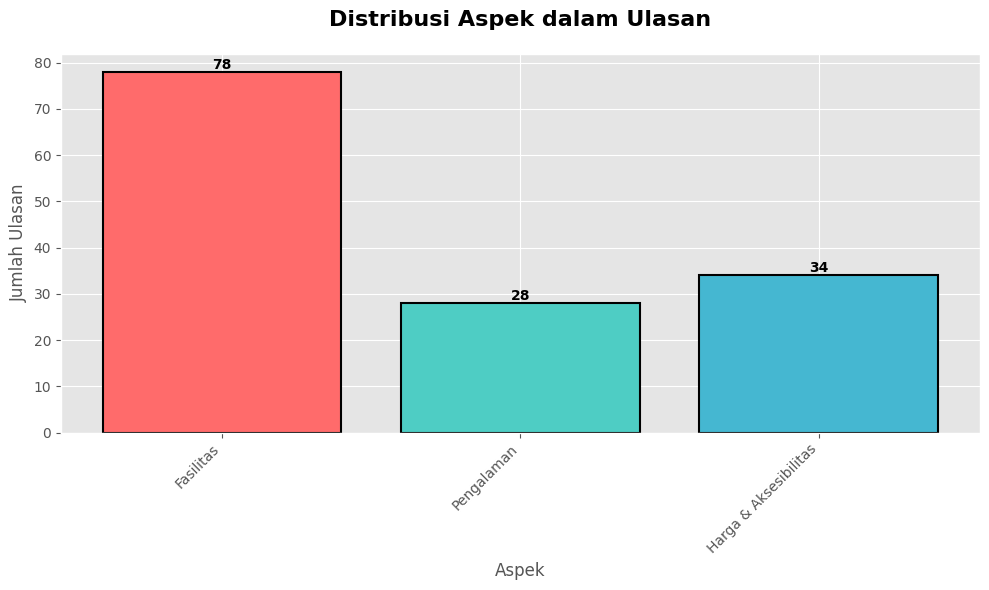

In [16]:
print(f"\n{'='*60}")
print(f"ASPECT-BASED CLASSIFICATION")
print(f"{'='*60}")

# Definisi keyword untuk setiap aspek
aspect_keywords = {
    'Fasilitas': [
        'gedung', 'ruang', 'kelas', 'ac', 'toilet', 'listrik', 'parkir',
        'perpustakaan', 'kantin', 'wifi', 'fasilitas', 'lab', 'laboratorium',
        'lapangan', 'tempat', 'bangunan', 'akses internet', 'mushola',
        'masjid', 'aula', 'auditorium'
    ],
    'Pengalaman': [
        'pelayanan', 'staff', 'pegawai', 'dosen', 'karyawan', 'satpam',
        'keamanan', 'proses', 'administrasi', 'suasana', 'lingkungan',
        'ramah', 'respon', 'pengalaman', 'ketertiban', 'layanan', 'service',
        'sikap', 'profesional', 'cepat', 'lambat'
    ],
    'Harga_Aksesibilitas': [
        'harga', 'murah', 'mahal', 'biaya', 'uang', 'ukt', 'bayar',
        'lokasi', 'akses', 'transportasi', 'jalan', 'arah', 'parkir berbayar',
        'terjangkau', 'ekonomis', 'strategis', 'dekat', 'jauh'
    ]
}

def classify_aspect(text):
    """
    Klasifikasi aspek berdasarkan keyword matching (multi-label)
    """
    aspects = []
    text_lower = text.lower()

    for aspect, keywords in aspect_keywords.items():
        if any(keyword in text_lower for keyword in keywords):
            aspects.append(aspect)

    return aspects if aspects else ['General']

# Terapkan klasifikasi aspek
df['aspects'] = df['clean_text'].apply(classify_aspect)

# Buat kolom binary untuk setiap aspek
df['has_Fasilitas'] = df['aspects'].apply(lambda x: 1 if 'Fasilitas' in x else 0)
df['has_Pengalaman'] = df['aspects'].apply(lambda x: 1 if 'Pengalaman' in x else 0)
df['has_Harga_Aksesibilitas'] = df['aspects'].apply(lambda x: 1 if 'Harga_Aksesibilitas' in x else 0)

# Statistik aspek
print("\nDistribusi Aspek:")
print(f"Fasilitas: {df['has_Fasilitas'].sum()} ulasan")
print(f"Pengalaman: {df['has_Pengalaman'].sum()} ulasan")
print(f"Harga & Aksesibilitas: {df['has_Harga_Aksesibilitas'].sum()} ulasan")

# Visualisasi distribusi aspek
aspect_counts = {
    'Fasilitas': df['has_Fasilitas'].sum(),
    'Pengalaman': df['has_Pengalaman'].sum(),
    'Harga & Aksesibilitas': df['has_Harga_Aksesibilitas'].sum()
}

plt.figure(figsize=(10, 6))
bars = plt.bar(aspect_counts.keys(), aspect_counts.values(),
               color=['#FF6B6B', '#4ECDC4', '#45B7D1'], edgecolor='black', linewidth=1.5)
plt.title('Distribusi Aspek dalam Ulasan', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Aspek', fontsize=12)
plt.ylabel('Jumlah Ulasan', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Tambahkan label nilai di atas bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('distribusi_aspek.png', dpi=300, bbox_inches='tight')
plt.show()

**BAGIAN 8: SENTIMENT LABELING**


SENTIMENT LABELING

Distribusi Sentimen:
sentiment
Positif    265
Netral      15
Negatif     14
Name: count, dtype: int64

Persentase:
sentiment
Positif    90.136054
Netral      5.102041
Negatif     4.761905
Name: proportion, dtype: float64


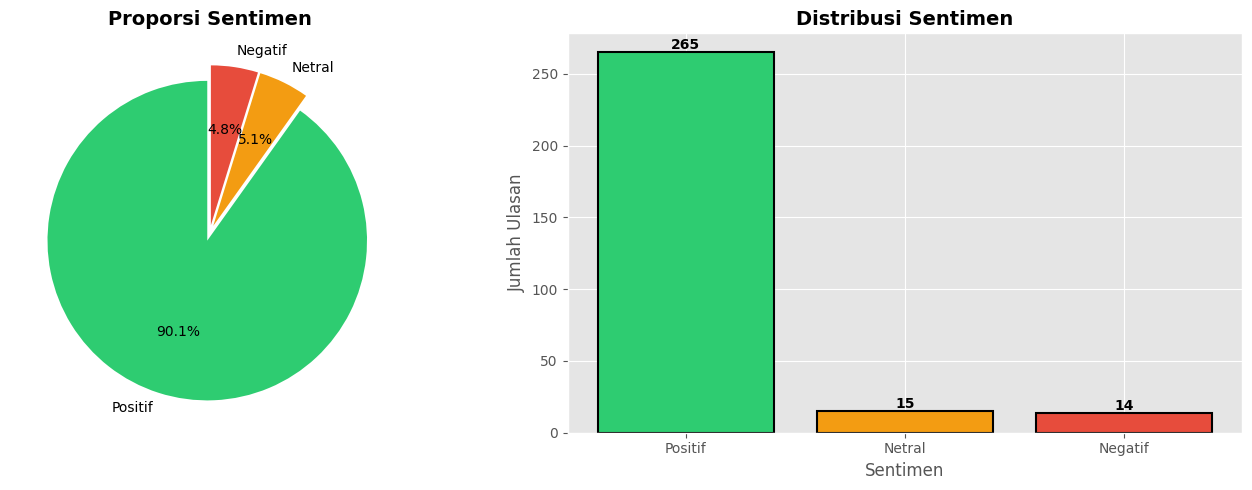

In [18]:
print(f"\n{'='*60}")
print(f"SENTIMENT LABELING")
print(f"{'='*60}")

def label_sentiment_from_stars(stars):
    """
    Labeling sentimen berdasarkan rating bintang
    """
    if stars >= 4:
        return 'Positif'
    elif stars == 3:
        return 'Netral'
    else:
        return 'Negatif'

# Terapkan labeling
df['sentiment'] = df['stars'].apply(label_sentiment_from_stars)

# Distribusi sentimen
sentiment_dist = df['sentiment'].value_counts()
print("\nDistribusi Sentimen:")
print(sentiment_dist)
print(f"\nPersentase:")
print(df['sentiment'].value_counts(normalize=True) * 100)

# Visualisasi distribusi sentimen
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
colors = ['#2ECC71', '#F39C12', '#E74C3C']
axes[0].pie(sentiment_dist.values, labels=sentiment_dist.index, autopct='%1.1f%%',
            startangle=90, colors=colors, explode=(0.05, 0.05, 0.05))
axes[0].set_title('Proporsi Sentimen', fontsize=14, fontweight='bold')

# Bar chart
bars = axes[1].bar(sentiment_dist.index, sentiment_dist.values,
                    color=colors, edgecolor='black', linewidth=1.5)
axes[1].set_title('Distribusi Sentimen', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Sentimen')
axes[1].set_ylabel('Jumlah Ulasan')

for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                 f'{int(height)}',
                 ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('distribusi_sentimen.png', dpi=300, bbox_inches='tight')
plt.show()

**BAGIAN 9: FEATURE ENGINEERING**

In [20]:
print(f"\n{'='*60}")
print(f"FEATURE ENGINEERING")
print(f"{'='*60}")

# TF-IDF Vectorization
print("\nMembuat TF-IDF features...")

# Gunakan unigram dan bigram
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.8
)

X_tfidf = tfidf_vectorizer.fit_transform(df['clean_text'])

print(f"✓ TF-IDF features dibuat!")
print(f"Dimensi features: {X_tfidf.shape}")
print(f"Jumlah vocabulary: {len(tfidf_vectorizer.vocabulary_)}")

# Tambahkan features numerik
additional_features = df[['stars', 'text_length', 'word_count']].values

# Gabungkan dengan TF-IDF
from scipy.sparse import hstack
X_combined = hstack([X_tfidf, additional_features])

print(f"Dimensi features gabungan: {X_combined.shape}")

# Target variable
y = df['sentiment']

print(f"\n{'='*60}")
print(f"SUMMARY DATASET UNTUK MODELING")
print(f"{'='*60}")
print(f"Total sampel: {len(df)}")
print(f"Total features: {X_combined.shape[1]}")
print(f"Distribusi target:")
print(y.value_counts())

# Simpan hasil preprocessing
df.to_csv('dataset_preprocessed.csv', index=False)
print(f"\n✓ Dataset preprocessed disimpan ke 'dataset_preprocessed.csv'")

print("\n" + "="*60)
print("PREPROCESSING DAN FEATURE ENGINEERING SELESAI!")
print("="*60)
print("\nSelanjutnya: Modeling dengan SVM")
print("Jalankan cell berikutnya untuk training model...")


FEATURE ENGINEERING

Membuat TF-IDF features...
✓ TF-IDF features dibuat!
Dimensi features: (294, 428)
Jumlah vocabulary: 428
Dimensi features gabungan: (294, 431)

SUMMARY DATASET UNTUK MODELING
Total sampel: 294
Total features: 431
Distribusi target:
sentiment
Positif    265
Netral      15
Negatif     14
Name: count, dtype: int64

✓ Dataset preprocessed disimpan ke 'dataset_preprocessed.csv'

PREPROCESSING DAN FEATURE ENGINEERING SELESAI!

Selanjutnya: Modeling dengan SVM
Jalankan cell berikutnya untuk training model...
